# Exercises week 41
### By Fredrik Stensson, Michele Tognoni and Sigurd Vargdal

In this notebook we'll experiment on the implementation of various types of gradient descent.

The idea is to get comfortable with the algorithm in a safe environment such as jupyter before implementing it in a more structured way in the project.

After writing this notebook, we already started working on the refactoring of the code using classes in order to include those in the project.

In [1]:
# Imports:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import grad
sns.set_theme(style="whitegrid")
np.random.seed(42)

Simple function to use for analysis
$$
f(x) = a_0 + a_1 x + a_2 x^2
$$

In [2]:
def f(x,coeff):
    deg = len(coeff)
    poly = 0
    for i in range(deg):
        poly += coeff[i]*x**(i)
    return poly

In [3]:
# plotting function for later:
def plot_error(ols,ridge,lamb,title,yscale):
    plt.figure(figsize=(10,6))
    plt.plot(ols, c='r', label='OLS')
    plt.plot(ridge, c='b', label=f'Ridge, lambda: {lamb}')
    plt.xlabel('itteration')
    plt.ylabel('MSE')
    plt.yscale(yscale)
    plt.xscale('log')
    plt.title(title)
    plt.legend()
    plt.show()

### Data and regression
We will firstly implement the cost function of both ordinary least squares (OLS) and Ridge regression:

In [4]:
def cost_ols(y,X,beta):
    '''OLS cost function'''
    return (y-X@beta).T @ (y-X@beta)

In [5]:
def cost_ridge(y,X,beta,alpha):
    '''Ridge cost function'''
    return (y-X@beta).T@(y-X@beta) + alpha*(beta.T@beta)

Next we define some polynomial of degree deg and defined at $n$ points.

In [6]:
# Define example data
n = 100
deg = 3
x = np.linspace(0,2,n).reshape(n,1)
coeff = np.random.rand(deg)
y = f(x,coeff)

Now we set up the esentials that will be used in the rest of the optimization methods. Firstly we construct a design matrix for the 1 polynomial fit to the data. We also introduce the learning rate which is the "worst" eigenvalue of the Hessian defined as $H=X^TX$.

In [7]:
# Design matrix:
X = np.c_[np.ones((n,1)), x]

# OLS inversion:
XT_X = X.T @ X
beta_OLS = np.linalg.inv(XT_X) @ (X.T @ y)

# Ridge:
I = np.identity(2)
lamb = 0.0001
beta_ridge = np.linalg.inv(XT_X + lamb*I) @ (X.T @ y)

# Hessian matrix:
Hes = (2.0/n)* XT_X

# Eigen values of hessioan:
eigvals = np.linalg.eigvals(Hes)
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)
eta = 1.0/np.max(eigvals)
Niterations = 1000

# Analytic prediction:
ypredict2_ols = X.dot(beta_OLS)
ypredict2_ridge = X.dot(beta_ridge)

error_ols = np.mean((y-ypredict2_ols)**2)
error_ridge = np.mean((y-ypredict2_ridge)**2)

Our first approach will be normal GD:

In [8]:
# GD:
error_ols_GD = np.empty(Niterations)
error_ridge_GD = np.empty(Niterations)
for iter in range(Niterations):
    gradients_ols = 2.0/n*X.T @ ((X @ theta_ols)-y)
    theta_ols -= eta*gradients_ols
    gradients_ridge = (-2.0 / n) * X.T @ (y - X @ theta_ridge) + 2 * lamb * theta_ridge
    theta_ridge -= eta*gradients_ridge

    # Make predictions:
    ypredict_ols = X.dot(theta_ols)
    ypredict_ridge = X.dot(theta_ridge)
    
    error_ols_GD[iter] = np.mean((y-ypredict_ols)**2)
    error_ridge_GD[iter] = np.mean((y-ypredict_ridge)**2)

We plot to see how the MES changes for each iteration.

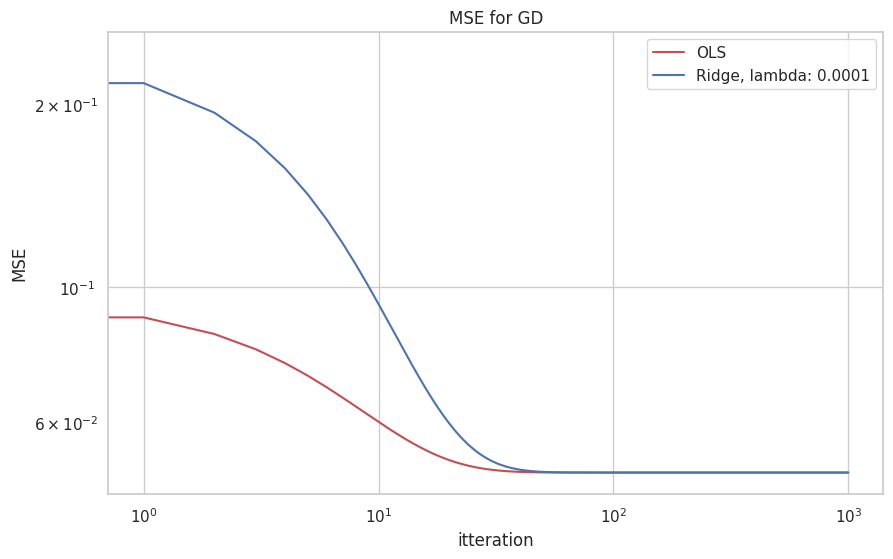

In [9]:
# Plot results:
plot_error(error_ols_GD,error_ridge_GD,lamb,'MSE for GD','log')

We can see that the MSE converges as about $10^{1.5}$. We will now do the same with GD but adding momentum to the opimization. For the $\gamma$ of the momentum we simply draw a random number between $0$ and $1$.

In [10]:
# GD with momentum:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)
gamma = np.random.rand()
v_ols = 0
v_ridge = 0
error_ols_GD_momentum = np.empty(Niterations)
error_ridge_GD_momentum = np.empty(Niterations)
for iter in range(Niterations):
    gradients_ols = 2.0/n*X.T @ ((X @ theta_ols)-y)
    v_ols = gamma*v_ols + eta*gradients_ols
    theta_ols -= v_ols
    gradients_ridge = (-2.0 / n) * X.T @ (y - X @ theta_ridge) + 2 * lamb * theta_ridge
    v_ridge = gamma*v_ridge + eta*gradients_ridge
    theta_ridge -= v_ridge

    # Make predictions:
    ypredict_ols = X.dot(theta_ols)
    ypredict_ridge = X.dot(theta_ridge)
    
    error_ols_GD_momentum[iter] = np.mean((y-ypredict_ols)**2)
    error_ridge_GD_momentum[iter] = np.mean((y-ypredict_ridge)**2)

We plot these results as well:

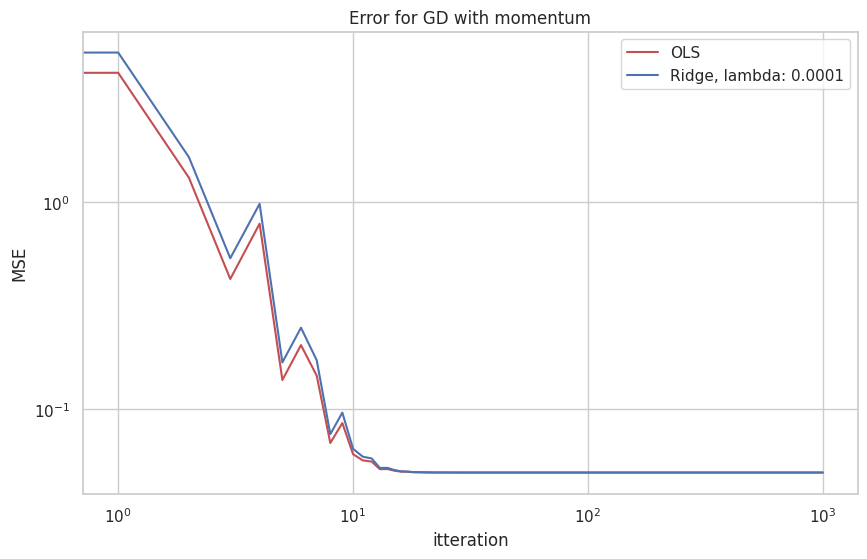

In [11]:
plot_error(error_ols_GD_momentum,error_ridge_GD_momentum,lamb,'Error for GD with momentum','log')

We clearly see more turbulet but faster convergence. Now the MSE has almost converged as $10$ iterations.

We move on to implementing SGD. We first do it without momentum.

In [12]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        eta = learning_schedule(epoch*m+i)

        # calculate update
        theta_ols -= eta*gradients_ols

        theta_ridge -= eta*gradients_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

We plot this aswell:

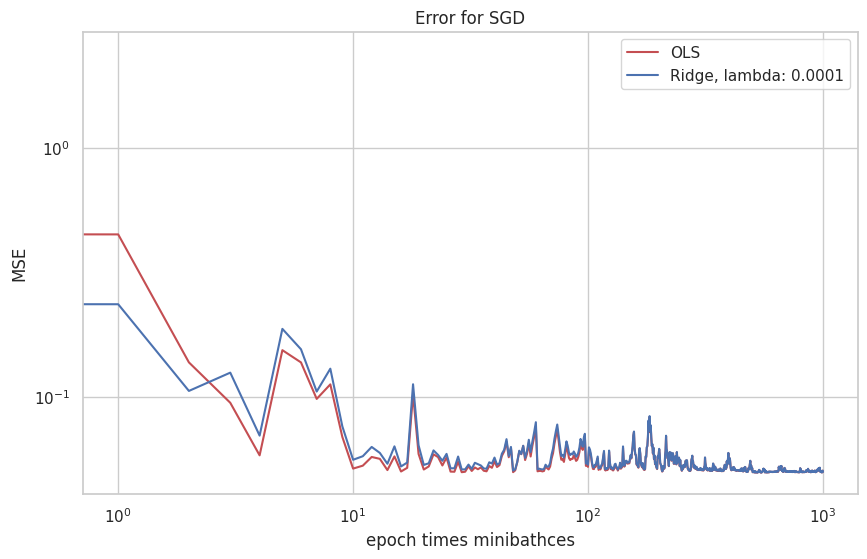

In [13]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
plt.xscale('log')
plt.title('Error for SGD')
plt.legend()
plt.show()

Here we see the fast convergence but with alot noice around the bottom. This is hard to tell what comes from. It might be that the learning rate is tuned too late.

Now SGD with momentum:

In [14]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

change_ols = 0.0
change_ridge = 0.0
delta_momentum = 0.3

for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        eta = learning_schedule(epoch*m+i)

        # calculate update
        new_change_ols = eta*gradients_ols+delta_momentum*change_ols
        theta_ols -= new_change_ols
        change_ols = new_change_ols

        new_change_ridge = eta*gradients_ridge+delta_momentum*change_ridge
        theta_ridge -= new_change_ridge
        change_ridge = new_change_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

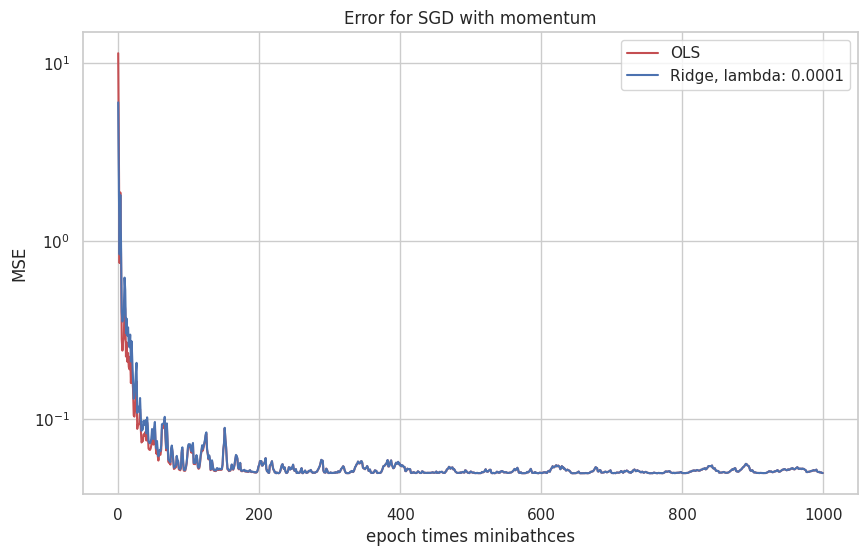

In [15]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for SGD with momentum')
plt.legend()
plt.show()

This also has that very noisy convergence which never realy seems to stabelize fully.

Implementing Adagrad For GD without momentum This allows us to tune the learningrate. For Adagrad we scale the learning rate by the norm of the gradient.

In [16]:
training_gradient_ols = grad(cost_ols,2)
training_gradient_ridge = grad(cost_ridge,2)

In [17]:
# GD:
# Niterations = 10
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

error_ols_GD = np.empty(Niterations)
error_ridge_GD = np.empty(Niterations)

# Initialize sum of squared gradients for Adagrad
squared_gradients_ols = np.zeros((2,1))
squared_gradients_ridge = np.zeros((2,1))
eta = 0.1
delta = 1e-8
for iter in range(Niterations):
    gradients_ols = (1/n)*training_gradient_ols(y,X,theta_ols)
    gradients_ridge = (1/n)*training_gradient_ridge(y,X,theta_ridge,lamb)
    
    # Update squared gradient sum for Adagrad
    squared_gradients_ols += gradients_ols**2
    squared_gradients_ridge += gradients_ridge**2

    # Adagrad updates
    theta_ols -= (eta / (np.sqrt(squared_gradients_ols) + delta)) * gradients_ols
    theta_ridge -= (eta / (np.sqrt(squared_gradients_ridge) + delta)) * gradients_ridge
    
    # Make predictions:
    ypredict_ols = X.dot(theta_ols)
    ypredict_ridge = X.dot(theta_ridge)
    
    error_ols_GD[iter] = np.mean((y-ypredict_ols)**2)
    error_ridge_GD[iter] = np.mean((y-ypredict_ridge)**2)

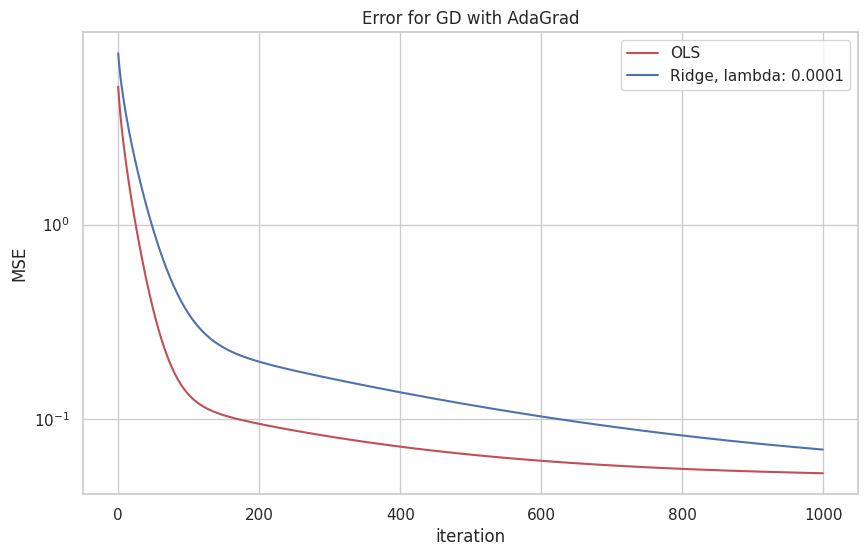

In [18]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_GD, c='r', label='OLS')
plt.plot(error_ridge_GD, c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for GD with AdaGrad')
plt.legend()
plt.show()

Adagrad for GD with momentum:

In [19]:
# GD with momentum:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)
# gamma = np.random.rand()
v_ols = 0
v_ridge = 0

squared_gradients_ols = np.zeros((2,1))
squared_gradients_ridge = np.zeros((2,1))

error_ols_GD = np.empty(Niterations)
error_ridge_GD = np.empty(Niterations)

delta = 1e-8
for iter in range(Niterations):
    gradients_ols = (1.0/n)*training_gradient_ols(y,X,theta_ols)
    gradients_ridge = (1.0/n)*training_gradient_ridge(y,X,theta_ridge,lamb)
    
    squared_gradients_ols += gradients_ols**2
    squared_gradients_ridge += gradients_ridge**2

    adjusted_eta_ols = eta / (np.sqrt(squared_gradients_ols) + delta)
    adjusted_eta_ridge = eta / (np.sqrt(squared_gradients_ridge) + delta)

    v_ols = gamma*v_ols + adjusted_eta_ols*gradients_ols
    v_ridge = gamma*v_ridge + adjusted_eta_ridge*gradients_ridge
    
    theta_ols -= v_ols
    theta_ridge -= v_ridge

    # Make predictions:
    ypredict_ols = X.dot(theta_ols)
    ypredict_ridge = X.dot(theta_ridge)
    
    error_ols_GD[iter] = np.mean((y-ypredict_ols)**2)
    error_ridge_GD[iter] = np.mean((y-ypredict_ridge)**2)

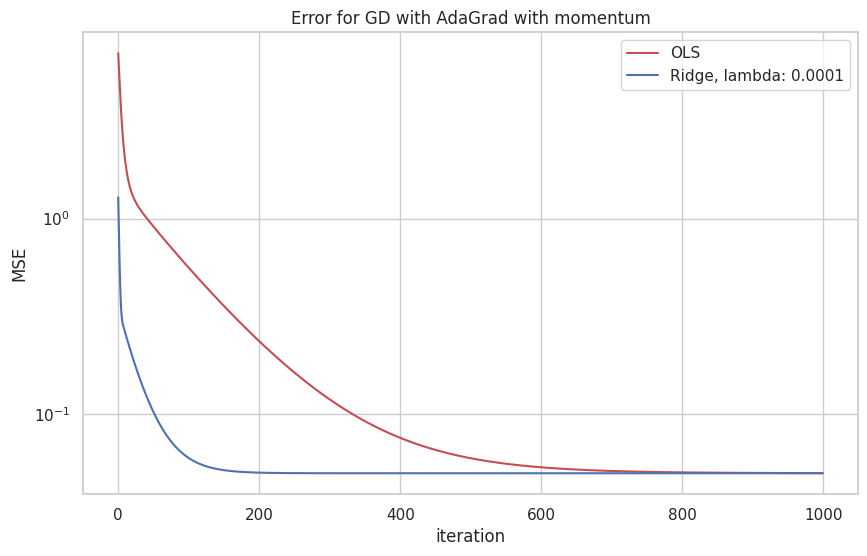

In [20]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_GD, c='r', label='OLS')
plt.plot(error_ridge_GD, c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for GD with AdaGrad with momentum')
plt.legend()
plt.show()

Implementing AdaGrad for SGD without momentum

In [21]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches

error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))

squared_gradients_ols = np.zeros((2,1))
squared_gradients_ridge = np.zeros((2,1))

t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)
delta = 1e-8
for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        squared_gradients_ols += gradients_ols*gradients_ols
        squared_gradients_ridge += gradients_ridge*gradients_ridge

        eta = learning_schedule(epoch*m+i)

        adjusted_eta_ols = eta/(np.sqrt(squared_gradients_ols)+delta)
        adjusted_eta_ridge = eta/(np.sqrt(squared_gradients_ridge)+delta)

        # calculate update
        theta_ols -= adjusted_eta_ols*gradients_ols

        theta_ridge -= adjusted_eta_ridge*gradients_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

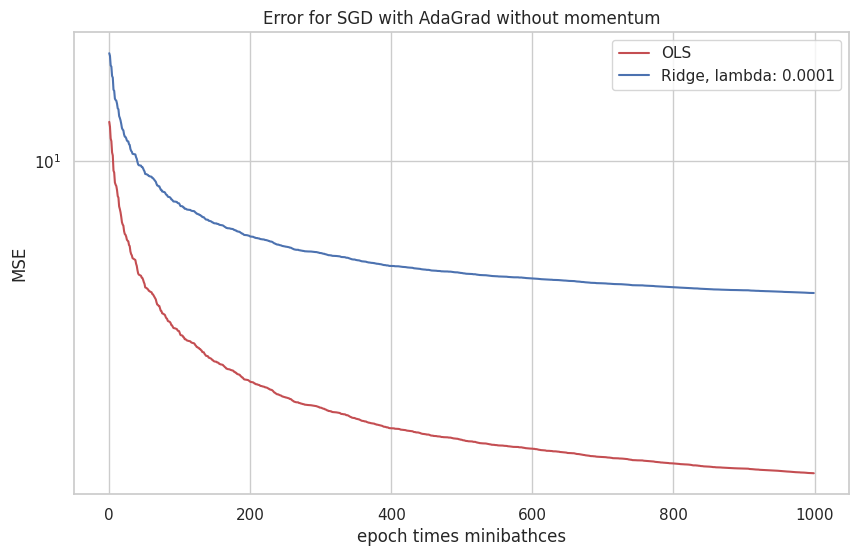

In [22]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for SGD with AdaGrad without momentum')
plt.legend()
plt.show()

Now SGD with Adagrad and momentum:

In [23]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

squared_gradients_ols = np.zeros((2,1))
squared_gradients_ridge = np.zeros((2,1))

change_ols = 0.0
change_ridge = 0.0
delta_momentum = 0.3
delta = 1e-8
for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        squared_gradients_ols += gradients_ols*gradients_ols
        squared_gradients_ridge += gradients_ridge*gradients_ridge

        eta = learning_schedule(epoch*m+i)
        adjusted_eta_ols = eta/(np.sqrt(squared_gradients_ols) + delta)
        adjusted_eta_ridge = eta/(np.sqrt(squared_gradients_ridge) + delta)

        # calculate update
        new_change_ols = adjusted_eta_ols*gradients_ols+delta_momentum*change_ols
        theta_ols -= new_change_ols
        change_ols = new_change_ols

        new_change_ridge = adjusted_eta_ridge*gradients_ridge+delta_momentum*change_ridge
        theta_ridge -= new_change_ridge
        change_ridge = new_change_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

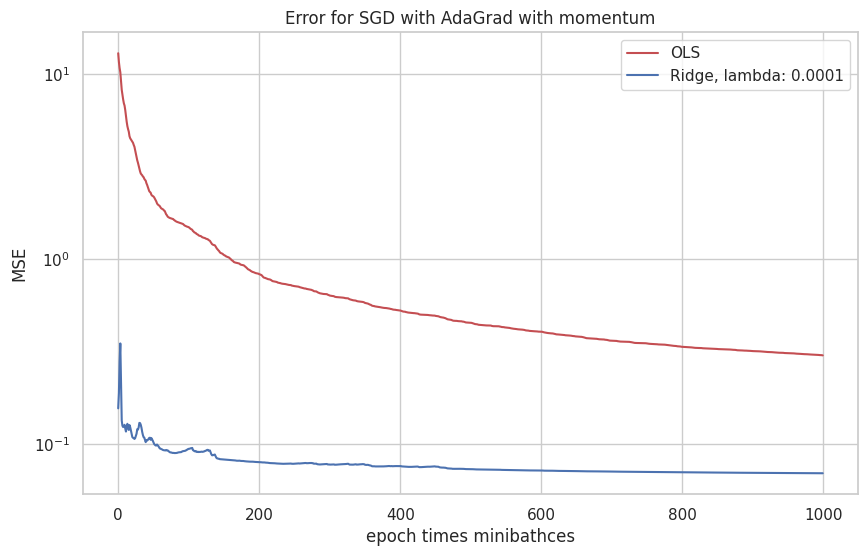

In [24]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for SGD with AdaGrad with momentum')
plt.legend()
plt.show()

Lastly we will look into RMSprop and Adam to have for later use when tuning learning rates.

#### RMSprop
This algorithm adjusts the scaling of the gradient even further. Here is an example of the analysis for SGD without momentum:

In [25]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches

error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))

# t0, t1 = 5, 50
# def learning_schedule(t):
#     return t0/(t+t1)
eta = 0.01
rho = 0.99
delta = 1e-8
for epoch in range(n_epochs):
    squared_gradients_ols = np.zeros((2,1))
    squared_gradients_ridge = np.zeros((2,1))
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        squared_gradients_ols = (rho*squared_gradients_ols + (1-rho)*gradients_ols*gradients_ols)
        squared_gradients_ridge = (rho*squared_gradients_ridge + (1-rho)*gradients_ridge*gradients_ridge)

        # eta = learning_schedule(epoch*m+i)

        adjusted_eta_ols = eta/(np.sqrt(squared_gradients_ols)+delta)
        adjusted_eta_ridge = eta/(np.sqrt(squared_gradients_ridge)+delta)

        # calculate update
        theta_ols -= adjusted_eta_ols*gradients_ols

        theta_ridge -= adjusted_eta_ridge*gradients_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

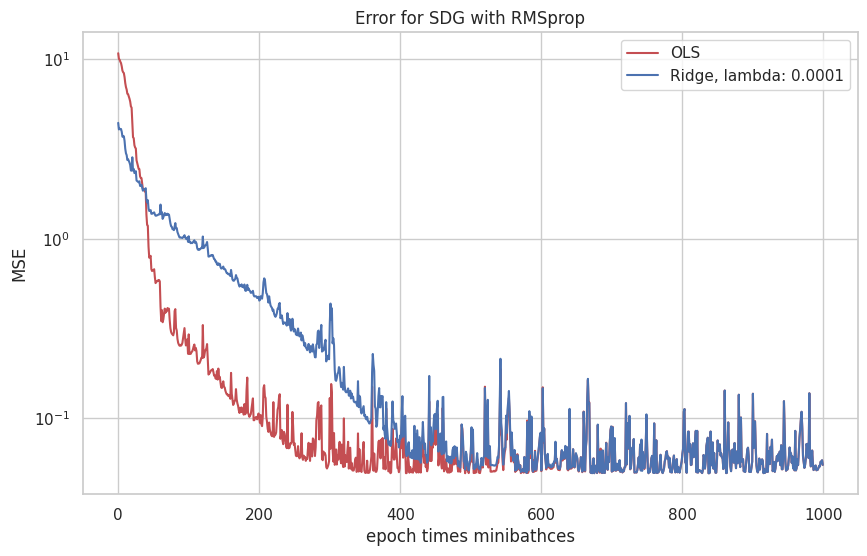

In [26]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for SDG with RMSprop')
plt.legend()
plt.show()

#### Adam
Lastly we look at the Adam algorithm. Now we scale the update even more. Lets look at SGD but without momentum:

In [27]:
# SGD:
theta_ols = np.random.randn(2,1)
theta_ridge = np.random.randn(2,1)

n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches

error_ols_SGD = np.empty((n_epochs,m))
error_ridge_SGD = np.empty((n_epochs,m))

eta = 0.01
beta1 = 0.99
beta2 = 0.999
delta = 1e-8

iter = 0
for epoch in range(n_epochs):
    ols_first_momentum = np.zeros((2,1))
    ols_second_momentum = np.zeros((2,1))
    ridge_first_momentum = np.zeros((2,1))
    ridge_second_momentum = np.zeros((2,1))
    iter += 1
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        
        gradients_ols = (2.0/M)*xi.T @ ((xi @ theta_ols)-yi)
        gradients_ridge = (-2.0/M)*xi.T @ (yi - xi @ theta_ridge) + 2 * lamb * theta_ridge

        ols_first_momentum = beta1*ols_first_momentum + (1-beta1)*(gradients_ols)
        ols_second_momentum = beta2*ols_second_momentum + (1-beta2)*(gradients_ols**2)
        
        first_term_ols = ols_first_momentum/(1.0-beta1**iter)
        second_term_ols = ols_second_momentum/(1.0-beta2**iter)

        ridge_first_momentum = beta1*ridge_first_momentum + (1-beta1)*gradients_ridge
        ridge_second_momentum = beta2*ridge_second_momentum + (1-beta2)*(gradients_ridge**2)
        
        first_term_ridge = ridge_first_momentum/(1.0-beta1**iter)
        second_term_ridge = ridge_second_momentum/(1.0-beta2**iter)

        # calculate update
        update_ols = eta*first_term_ols/(np.sqrt(second_term_ols)+delta)
        theta_ols -= update_ols

        update_ridge = eta*first_term_ridge/(np.sqrt(second_term_ridge)+delta)
        theta_ridge -= update_ridge
    
        # Make predictions:
        ypredict_ols = X.dot(theta_ols)
        ypredict_ridge = X.dot(theta_ridge)
            
        error_ols_SGD[epoch,i] = np.mean((y-ypredict_ols)**2)
        error_ridge_SGD[epoch,i] = np.mean((y-ypredict_ridge)**2)

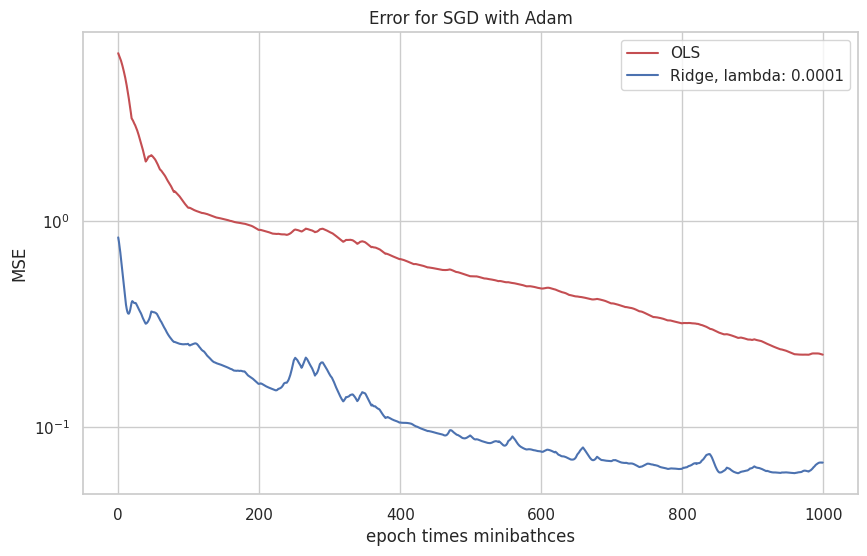

In [28]:
# Plot results:
plt.figure(figsize=(10,6))
plt.plot(error_ols_SGD.flatten(), c='r', label='OLS')
plt.plot(error_ridge_SGD.flatten(), c='b', label=f'Ridge, lambda: {lamb}')
plt.xlabel('epoch times minibathces')
plt.ylabel('MSE')
plt.yscale('log')
# plt.xscale('log')
plt.title('Error for SGD with Adam')
plt.legend()
plt.show()